In [ ]:
from qiskit.quantum_info import partial_trace, Statevector
from parametric_circuits import Ansatz
from qiskit import QuantumCircuit
import qiskit.quantum_info as qi
from qiskit import transpile
from qiskit import Aer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
def compute_ptrace(ket: np.ndarray, num_qubits: int) -> float:
    """Return the values of entanglement capability using meyer-wallach measure.
    Args:
        ket : (numpy.ndarray or list);Vector of amplitudes in 2**N dimensions
        num_qubits : (int)Number of qubits

    Returns:
        q: float; Q value for input ket
    """
    

    entanglement_sum = 0
    for k in range(num_qubits):

        trace_over = [q for q in range(num_qubits) if q != k]
        rho_k = partial_trace(ket, trace_over).data
        entanglement_sum += np.real((np.linalg.matrix_power(rho_k, 2)).trace())

    q = 2 * (1 - (1 / num_qubits) * entanglement_sum)

    return q


In [ ]:
def compute_vn_entropy(ket: np.ndarray, num_qubits: int) -> float:
    """Returns the entangling capabilility using von-neumann entropy.
    Args:
        ket : (numpy.ndarray or list);Vector of amplitudes in 2**N dimensions
        num_qubits : (int)Number of qubits

    Returns:
        q: float; Q value for input ket
    """


    qubit = list(range(num_qubits))  # list of qubits to trace over

    vn_entropy = 0

    for k in range(num_qubits):
        rho_k = qi.partial_trace(ket, qubit[:k] + qubit[k + 1 :]).data
        vn_entropy += qi.entropy(rho_k, base=np.exp(1))
    q = vn_entropy / num_qubits
    return q

In [ ]:
def meyer_wallach(num_params, feature_dim, layers, circuit_id) -> float:
        """
        Returns:
                net_entanglement_cap: The meyer-wallach entangling capacity of the
                                       given parametric circuit.
        """

        entanglement_cap = []

        for _ in range(num_params):
            
            parametric_circuit = Ansatz(layers + 1, feature_dim, circuit_id).get_ansatz()
            # transpiled_circ = transpile(parametric_circuit, backend, optimization_level=3)
            # job_sim = backend.run(transpiled_circ)
            # result_sim = job_sim.result()

            state_vector = Statevector(parametric_circuit)
            state_vector = np.array(state_vector)

            q_value = compute_ptrace(ket=state_vector, num_qubits=feature_dim)
            entanglement_cap.append(q_value)

        entanglement_cap = np.array(entanglement_cap)
        net_entanglement_cap = np.sum(entanglement_cap) / num_params

        return net_entanglement_cap

In [ ]:
def von_neumann(num_params,  feature_dim, layers, circuit_id) -> float:

        """
        Returns:
              net_entanglement_cap: The von_neumann entangling capacity of the given parametric circuit.
        """

        entanglement_cap = []

        for _ in range(num_params):

            parametric_circuit = Ansatz(layers + 1, feature_dim, circuit_id).get_ansatz()
            # transpiled_circ = transpile(parametric_circuit, backend, optimization_level=3)
            # job_sim = backend.run(transpiled_circ)
            # result_sim = job_sim.result()

            # state_vector = result_sim.get_statevector(transpiled_circ)
            state_vector = Statevector(parametric_circuit).data
            state_vector = np.array(state_vector)

            q_value = compute_vn_entropy(ket=state_vector, num_qubits=feature_dim)
            entanglement_cap.append(q_value)

        entanglement_cap = np.array(entanglement_cap)
        net_entanglement_cap = np.sum(entanglement_cap) / num_params

        return net_entanglement_cap

In [ ]:
# feature_dim = 4
# repitition = 2

# # Defining Custom Parametric Quantum Circuit for its entanglement capability measurement

# num_pars = feature_dim * repitition
# paravec = np.random.randn(num_pars)
# arg_count = 0
# circ = QuantumCircuit(feature_dim)
# for _ in range(repitition):
#     for i in range(feature_dim):
#         circ.h(i)
#     for i in reversed(range(feature_dim - 1)):
#         circ.cz(i + 1, i)
#     for i in range(feature_dim):
#         circ.rx(paravec[arg_count], i)
#         arg_count += 1
        
# backend = Aer.get_backend("statevector_simulator")
# ent_cap = meyer_wallach(num_params = 500, parametric_circuit = circ, backend=backend, feature_dim = feature_dim)
# print("ent_cap:", ent_cap)
# circ.draw("mpl")

In [ ]:
from parametric_circuits import Ansatz
import numpy as np
from qiskit import Aer
import pandas as pd


total_circuit = 10
feature_dim = 4
repitition = 5
# num_eval = 1
# entanglement_cap = np.zeros((total_circuit, repitition))
# backend = Aer.get_backend("statevector_simulator")
entanglement_cap = np.zeros((total_circuit, repitition))


for i in range(total_circuit):
    circuit_id = i + 1

    for layers in range(repitition):

        # ansatze = Ansatz(layers + 1, feature_dim, circuit_id).get_ansatz()
        ent_cap = meyer_wallach(num_params = 100, feature_dim = feature_dim, layers = layers, circuit_id = circuit_id)
        entanglement_cap[i, layers] = ent_cap
# df = pd.DataFrame(entanglement_cap)
index = ["Ansatz "+str(i+1) for i in range(total_circuit)]
df = pd.DataFrame({'Layer1':entanglement_cap[:,0], "Layer2":entanglement_cap[:,1], "Layer3":entanglement_cap[:,2],
                   "Layer4":entanglement_cap[:,3],"Layer5":entanglement_cap[:,4]}, index = index)
file_name = "entropy_run_5_Layers" 
df.to_csv(file_name + ".csv")

In [27]:
df = pd.read_csv('entropy_run_5_Layers.csv')
df

,Unnamed: 0,Layer1,Layer2,Layer3,Layer4,Layer5
0,Ansatz 1,8.437695e-17,6.661338e-17,-5.329071e-17,-6.661338e-18,-3.996803e-17
1,Ansatz 2,5.876058e-01,5.616569e-01,6.872466e-01,6.691458e-01,6.745053e-01
2,Ansatz 3,6.795815e-02,1.104183e-01,1.761202e-01,2.050545e-01,2.368738e-01
3,Ansatz 4,9.179237e-02,1.968364e-01,2.502683e-01,3.434750e-01,3.870123e-01
4,Ansatz 5,2.900011e-01,2.909965e-01,4.079778e-01,4.031235e-01,5.015488e-01
5,Ansatz 6,2.250896e-01,4.251459e-01,5.173749e-01,5.033830e-01,5.308837e-01
6,Ansatz 7,6.848304e-02,1.621814e-01,2.395246e-01,2.933399e-01,3.801676e-01
7,Ansatz 8,1.084780e-01,2.098626e-01,3.039005e-01,3.551965e-01,4.046898e-01
8,Ansatz 9,1.000000e+00,1.000000e+00,1.000000e+00,6.421021e-01,7.107636e-01
9,Ansatz 10,4.120364e-01,6.853307e-01,7.817893e-01,7.143181e-01,7.365146e-01


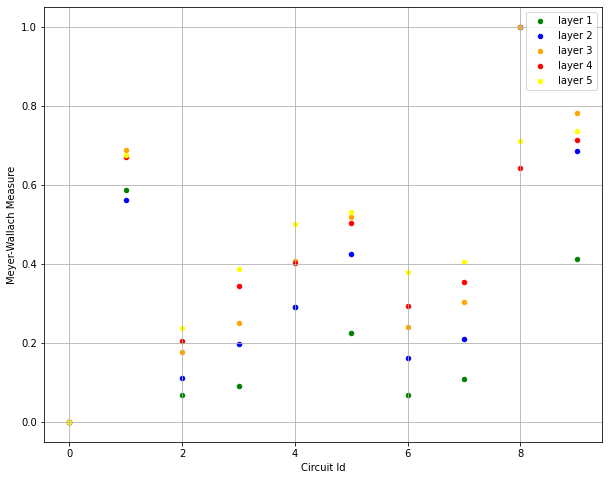

In [28]:
# import seaborn as sns
ax = plt.gca()
color = ['green', 'blue', 'orange', 'red', 'yellow']
for i in range(5):
    df.reset_index().plot.scatter(x = 'index', y = 'Layer'+str(i+1), color = color[i],marker = 'o', label = 'layer '+str(i+1), figsize = (10,8), grid = True, ax = ax)

ax.set_xlabel('Circuit Id')
ax.set_ylabel('Meyer-Wallach Measure')
plt.show()

